Processing Alpine...
Processing Ararat...
Processing Ballarat...
Processing Banyule...
Processing Bass Coast...
Processing Baw Baw...
Processing Boroondara...
Processing Brimbank...
Processing Campaspe...
Processing Cardinia...
Processing Casey...
Processing Central Goldfields...
Processing Colac-Otway...
Processing Corangamite...
Processing Darebin...
Processing East Gippsland...
Processing Frankston...
Processing Gannawarra...
Processing Glen Eira...
Processing Greater Bendigo...
Processing Greater Dandenong...
Processing Greater Geelong...
Processing Greater Shepparton...
Processing Hepburn...
Processing Hindmarsh...
Processing Hobsons Bay...
Processing Horsham...
Processing Hume...


/Users/xxu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processing Indigo...
Processing Knox...
Processing Macedon Ranges...
Processing Manningham...
Processing Maribyrnong...
Processing Maroondah...
Processing Melbourne...
Processing Melton...
Processing Mildura...
Processing Mitchell...
Processing Moira...
Processing Monash...


/Users/xxu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/xxu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Moonee Valley...
Processing Moorabool...
Processing Mount Alexander...
Processing Moyne...
Processing Murrindindi...
Processing Northern Grampians...
Processing South Gippsland...
Processing Southern Grampians...
Processing Stonnington...
Processing Surf Coast...


/Users/xxu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/xxu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Swan Hill...
Processing Towong...
Processing Wangaratta...
Processing Wellington...
Processing Whitehorse...
Processing Whittlesea...
Processing Wodonga...
Processing Wyndham...


/Users/xxu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/xxu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Yarra...
Processing Yarra Ranges...
The regions with the highest projected growth over the next three years:
Wyndham       36.821029
Whittlesea    36.120099
Moira         33.711697
Hume          29.329922
Casey         26.548160
Glen Eira     25.939525
Swan Hill     25.339529
Melbourne     24.245395
Monash        22.889746
Whitehorse    22.690086
dtype: float64
Price increase forecast saved to ../data/results/price_increase_forecast_SARIMA.csv


/var/folders/8_/gylgnm051zv9rk4m5lzq6c880000gn/T/ipykernel_22796/2852175773.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(top_regions))


Plot saved at ../plots/price_forecast_top10_SARIMA.png


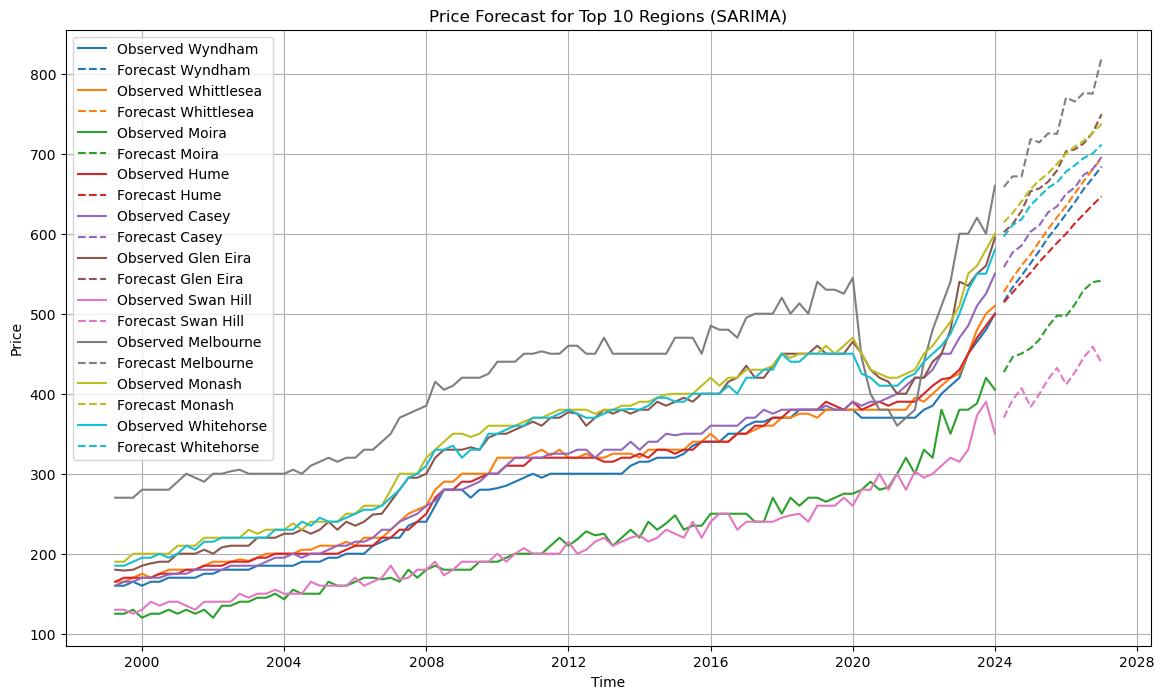

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re
import os
import sys
sys.path.append('..') 
from scripts.save_plot import save_plot

df = pd.read_csv('../data/curated/final_merged_data_sa2.csv')

price_columns = [col for col in df.columns if re.match(r'\b[A-Za-z]{3}\s\d{4}\smedian\b', col)]

df_prices = df[['LGA', 'SA2'] + price_columns]  

df_prices_unique = df_prices.groupby('LGA').first().reset_index()

price_columns_filtered = [col for col in df_prices_unique.columns if 'median' in col]

df_prices_unique.set_index('LGA', inplace=True)

df_prices_unique = df_prices_unique[price_columns_filtered]

df_prices_unique.columns = pd.to_datetime([col.replace(' median', '') for col in df_prices_unique.columns], errors='coerce', format='%b %Y')

df_prices_t = df_prices_unique.T

df_prices_t.index = pd.period_range(start='1999Q2', periods=len(df_prices_t.index), freq='Q')  

test_regions = df_prices_t.columns 

forecast_horizon = 12

predictions = {}

for region in test_regions:
    print(f"Processing {region}...")
    
    ts = df_prices_t[region].dropna()

    p, d, q = 1, 1, 1 
    P, D, Q, m = 1, 1, 1, 4  
    
    try:
        model = sm.tsa.SARIMAX(ts, order=(p, d, q), seasonal_order=(P, D, Q, m))
        sarima_fit = model.fit(disp=False)
    
        forecast = sarima_fit.get_forecast(steps=forecast_horizon)
        forecast_values = forecast.predicted_mean
    
        predictions[region] = forecast_values
    except Exception as e:
        print(f"Error processing {region}: {e}")

predictions_df = pd.DataFrame(predictions, index=pd.period_range(start=df_prices_t.index[-1] + 1, periods=forecast_horizon, freq='Q'))

current_prices = df_prices_t.iloc[-1][test_regions]

future_prices = predictions_df.iloc[-1]

price_increase = (future_prices - current_prices) / current_prices * 100

top_regions = price_increase.nlargest(10)  
print("The regions with the highest projected growth over the next three years:")
print(top_regions)

price_increase_df = pd.DataFrame({
    'LGA': price_increase.index,
    'Future Price Increase (%)': price_increase.values
})

# Define the output file path
output_path = '../data/results/price_increase_forecast_SARIMA.csv'
# Ensure the directory exists before saving the file
os.makedirs(os.path.dirname(output_path), exist_ok=True)
# Save the DataFrame to the specified CSV file
price_increase_df.to_csv(output_path, index=False)
print(f"Price increase forecast saved to {output_path}")

plt.figure(figsize=(14, 8))

colors = plt.cm.get_cmap('tab10', len(top_regions))  

for i, region in enumerate(top_regions.index):
    plt.plot(df_prices_t.index.to_timestamp(), df_prices_t[region], label=f"Observed {region}", color=colors(i))
    plt.plot(predictions_df.index.to_timestamp(), predictions_df[region], label=f"Forecast {region}", linestyle='--', color=colors(i))

plt.title("Price Forecast for Top 10 Regions (SARIMA)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

# Save the plot using the save_plot function
save_plot(plt.gcf(), 'price_forecast_top10_SARIMA.png', output_dir='../plots')
plt.show()



Processing Alpine...


11:45:27 - cmdstanpy - INFO - Chain [1] start processing
11:45:28 - cmdstanpy - INFO - Chain [1] done processing
11:45:28 - cmdstanpy - INFO - Chain [1] start processing
11:45:28 - cmdstanpy - INFO - Chain [1] done processing


Processing Ararat...


11:45:28 - cmdstanpy - INFO - Chain [1] start processing
11:45:28 - cmdstanpy - INFO - Chain [1] done processing


Processing Ballarat...


11:45:28 - cmdstanpy - INFO - Chain [1] start processing
11:45:28 - cmdstanpy - INFO - Chain [1] done processing


Processing Banyule...
Processing Bass Coast...


11:45:29 - cmdstanpy - INFO - Chain [1] start processing
11:45:29 - cmdstanpy - INFO - Chain [1] done processing
11:45:29 - cmdstanpy - INFO - Chain [1] start processing
11:45:29 - cmdstanpy - INFO - Chain [1] done processing


Processing Baw Baw...
Processing Boroondara...


11:45:29 - cmdstanpy - INFO - Chain [1] start processing
11:45:29 - cmdstanpy - INFO - Chain [1] done processing
11:45:29 - cmdstanpy - INFO - Chain [1] start processing
11:45:29 - cmdstanpy - INFO - Chain [1] done processing


Processing Brimbank...
Processing Campaspe...


11:45:29 - cmdstanpy - INFO - Chain [1] start processing
11:45:29 - cmdstanpy - INFO - Chain [1] done processing
11:45:30 - cmdstanpy - INFO - Chain [1] start processing
11:45:30 - cmdstanpy - INFO - Chain [1] done processing


Processing Cardinia...
Processing Casey...


11:45:30 - cmdstanpy - INFO - Chain [1] start processing
11:45:30 - cmdstanpy - INFO - Chain [1] done processing
11:45:30 - cmdstanpy - INFO - Chain [1] start processing
11:45:30 - cmdstanpy - INFO - Chain [1] done processing


Processing Central Goldfields...
Processing Colac-Otway...


11:45:30 - cmdstanpy - INFO - Chain [1] start processing
11:45:30 - cmdstanpy - INFO - Chain [1] done processing
11:45:30 - cmdstanpy - INFO - Chain [1] start processing
11:45:30 - cmdstanpy - INFO - Chain [1] done processing


Processing Corangamite...


11:45:31 - cmdstanpy - INFO - Chain [1] start processing
11:45:31 - cmdstanpy - INFO - Chain [1] done processing


Processing Darebin...
Processing East Gippsland...


11:45:31 - cmdstanpy - INFO - Chain [1] start processing
11:45:31 - cmdstanpy - INFO - Chain [1] done processing
11:45:31 - cmdstanpy - INFO - Chain [1] start processing
11:45:31 - cmdstanpy - INFO - Chain [1] done processing


Processing Frankston...
Processing Gannawarra...


11:45:31 - cmdstanpy - INFO - Chain [1] start processing
11:45:31 - cmdstanpy - INFO - Chain [1] done processing
11:45:31 - cmdstanpy - INFO - Chain [1] start processing
11:45:31 - cmdstanpy - INFO - Chain [1] done processing


Processing Glen Eira...


11:45:32 - cmdstanpy - INFO - Chain [1] start processing
11:45:32 - cmdstanpy - INFO - Chain [1] done processing


Processing Greater Bendigo...


11:45:32 - cmdstanpy - INFO - Chain [1] start processing
11:45:32 - cmdstanpy - INFO - Chain [1] done processing


Processing Greater Dandenong...
Processing Greater Geelong...


11:45:32 - cmdstanpy - INFO - Chain [1] start processing
11:45:32 - cmdstanpy - INFO - Chain [1] done processing
11:45:32 - cmdstanpy - INFO - Chain [1] start processing
11:45:32 - cmdstanpy - INFO - Chain [1] done processing


Processing Greater Shepparton...
Processing Hepburn...


11:45:33 - cmdstanpy - INFO - Chain [1] start processing
11:45:33 - cmdstanpy - INFO - Chain [1] done processing
11:45:33 - cmdstanpy - INFO - Chain [1] start processing
11:45:33 - cmdstanpy - INFO - Chain [1] done processing


Processing Hindmarsh...
Processing Hobsons Bay...


11:45:33 - cmdstanpy - INFO - Chain [1] start processing
11:45:33 - cmdstanpy - INFO - Chain [1] done processing
11:45:33 - cmdstanpy - INFO - Chain [1] start processing
11:45:33 - cmdstanpy - INFO - Chain [1] done processing


Processing Horsham...
Processing Hume...


11:45:33 - cmdstanpy - INFO - Chain [1] start processing
11:45:33 - cmdstanpy - INFO - Chain [1] done processing
11:45:33 - cmdstanpy - INFO - Chain [1] start processing
11:45:34 - cmdstanpy - INFO - Chain [1] done processing


Processing Indigo...
Processing Knox...


11:45:34 - cmdstanpy - INFO - Chain [1] start processing
11:45:34 - cmdstanpy - INFO - Chain [1] done processing
11:45:34 - cmdstanpy - INFO - Chain [1] start processing
11:45:34 - cmdstanpy - INFO - Chain [1] done processing


Processing Macedon Ranges...
Processing Manningham...


11:45:34 - cmdstanpy - INFO - Chain [1] start processing
11:45:34 - cmdstanpy - INFO - Chain [1] done processing
11:45:34 - cmdstanpy - INFO - Chain [1] start processing
11:45:34 - cmdstanpy - INFO - Chain [1] done processing


Processing Maribyrnong...
Processing Maroondah...


11:45:34 - cmdstanpy - INFO - Chain [1] start processing
11:45:34 - cmdstanpy - INFO - Chain [1] done processing
11:45:35 - cmdstanpy - INFO - Chain [1] start processing
11:45:35 - cmdstanpy - INFO - Chain [1] done processing


Processing Melbourne...
Processing Melton...


11:45:35 - cmdstanpy - INFO - Chain [1] start processing
11:45:35 - cmdstanpy - INFO - Chain [1] done processing
11:45:35 - cmdstanpy - INFO - Chain [1] start processing
11:45:35 - cmdstanpy - INFO - Chain [1] done processing


Processing Mildura...


11:45:35 - cmdstanpy - INFO - Chain [1] start processing
11:45:35 - cmdstanpy - INFO - Chain [1] done processing


Processing Mitchell...


11:45:35 - cmdstanpy - INFO - Chain [1] start processing
11:45:36 - cmdstanpy - INFO - Chain [1] done processing


Processing Moira...
Processing Monash...


11:45:36 - cmdstanpy - INFO - Chain [1] start processing
11:45:36 - cmdstanpy - INFO - Chain [1] done processing
11:45:36 - cmdstanpy - INFO - Chain [1] start processing
11:45:36 - cmdstanpy - INFO - Chain [1] done processing


Processing Moonee Valley...
Processing Moorabool...


11:45:36 - cmdstanpy - INFO - Chain [1] start processing
11:45:36 - cmdstanpy - INFO - Chain [1] done processing
11:45:36 - cmdstanpy - INFO - Chain [1] start processing
11:45:36 - cmdstanpy - INFO - Chain [1] done processing


Processing Mount Alexander...
Processing Moyne...


11:45:36 - cmdstanpy - INFO - Chain [1] start processing
11:45:36 - cmdstanpy - INFO - Chain [1] done processing
11:45:37 - cmdstanpy - INFO - Chain [1] start processing
11:45:37 - cmdstanpy - INFO - Chain [1] done processing


Processing Murrindindi...
Processing Northern Grampians...


11:45:37 - cmdstanpy - INFO - Chain [1] start processing
11:45:37 - cmdstanpy - INFO - Chain [1] done processing
11:45:37 - cmdstanpy - INFO - Chain [1] start processing
11:45:37 - cmdstanpy - INFO - Chain [1] done processing


Processing South Gippsland...
Processing Southern Grampians...


11:45:37 - cmdstanpy - INFO - Chain [1] start processing
11:45:37 - cmdstanpy - INFO - Chain [1] done processing
11:45:37 - cmdstanpy - INFO - Chain [1] start processing
11:45:37 - cmdstanpy - INFO - Chain [1] done processing


Processing Stonnington...
Processing Surf Coast...


11:45:37 - cmdstanpy - INFO - Chain [1] start processing
11:45:38 - cmdstanpy - INFO - Chain [1] done processing
11:45:38 - cmdstanpy - INFO - Chain [1] start processing
11:45:38 - cmdstanpy - INFO - Chain [1] done processing


Processing Swan Hill...
Processing Towong...


11:45:38 - cmdstanpy - INFO - Chain [1] start processing
11:45:38 - cmdstanpy - INFO - Chain [1] done processing
11:45:38 - cmdstanpy - INFO - Chain [1] start processing
11:45:38 - cmdstanpy - INFO - Chain [1] done processing


Processing Wangaratta...


11:45:38 - cmdstanpy - INFO - Chain [1] start processing
11:45:39 - cmdstanpy - INFO - Chain [1] done processing


Processing Wellington...


11:45:39 - cmdstanpy - INFO - Chain [1] start processing
11:45:39 - cmdstanpy - INFO - Chain [1] done processing


Processing Whitehorse...
Processing Whittlesea...


11:45:39 - cmdstanpy - INFO - Chain [1] start processing
11:45:39 - cmdstanpy - INFO - Chain [1] done processing
11:45:39 - cmdstanpy - INFO - Chain [1] start processing
11:45:39 - cmdstanpy - INFO - Chain [1] done processing


Processing Wodonga...
Processing Wyndham...


11:45:39 - cmdstanpy - INFO - Chain [1] start processing
11:45:39 - cmdstanpy - INFO - Chain [1] done processing
11:45:39 - cmdstanpy - INFO - Chain [1] start processing
11:45:40 - cmdstanpy - INFO - Chain [1] done processing


Processing Yarra...
Processing Yarra Ranges...


11:45:40 - cmdstanpy - INFO - Chain [1] start processing
11:45:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/8_/gylgnm051zv9rk4m5lzq6c880000gn/T/ipykernel_22796/1274918839.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(top_regions))


The regions with the highest projected growth over the next three years:
Corangamite           23.764265
Alpine                21.938616
South Gippsland       21.164959
Wellington            21.066161
Moyne                 20.150627
Greater Bendigo       18.566806
Colac-Otway           18.141860
East Gippsland        16.642525
Baw Baw               16.396110
Greater Shepparton    16.384388
dtype: float64
Plot saved at ../plots/price_forecast_top10_Prophet.png


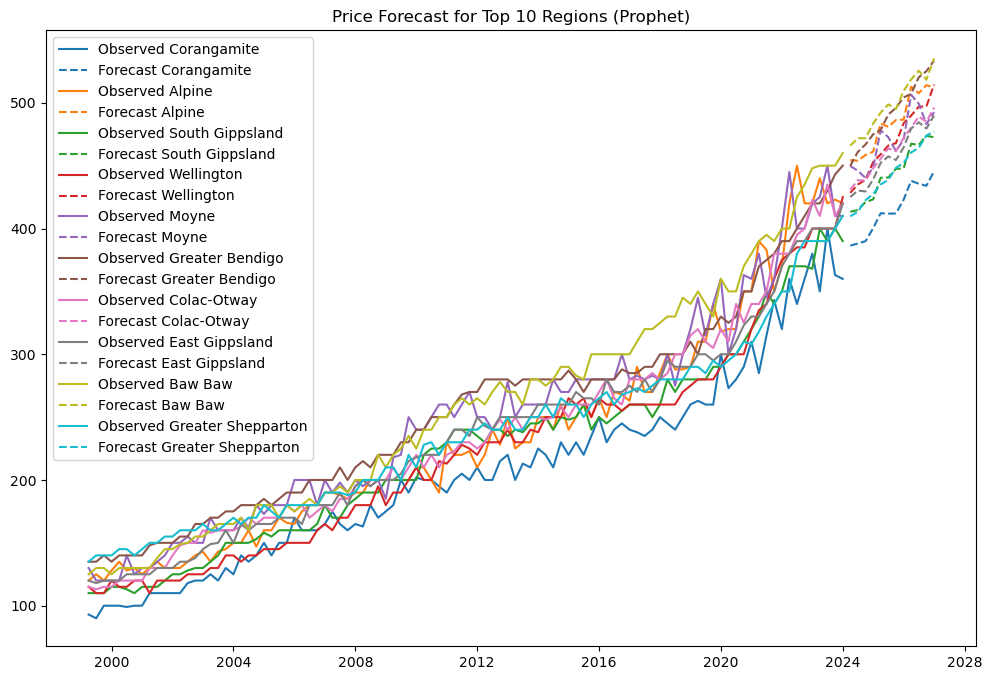

In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

df = pd.read_csv('../data/curated/final_merged_data_sa2.csv')

import re
price_columns = [col for col in df.columns if re.match(r'\b[A-Za-z]{3}\s\d{4}\smedian\b', col)]

df_prices = df[['LGA'] + price_columns]

df_prices_unique = df_prices.groupby('LGA').first()

df_prices_unique.columns = pd.to_datetime([col.replace(' median', '') for col in df_prices_unique.columns], errors='coerce', format='%b %Y')

df_prices_t = df_prices_unique.T

df_prices_t.index = pd.period_range(start='1999Q2', periods=len(df_prices_t.index), freq='Q') 

regions = df_prices_t.columns  

forecast_horizon = 12

predictions = {}

for region in regions:
    print(f"Processing {region}...")
    
    ts = df_prices_t[region].dropna()
    
    prophet_df = pd.DataFrame({
        'ds': ts.index.to_timestamp(),  
        'y': ts.values
    })
    
    model = Prophet()
    model.fit(prophet_df)
    
    future = model.make_future_dataframe(periods=forecast_horizon, freq='Q')
    
    forecast = model.predict(future)
    
    predictions[region] = forecast[['ds', 'yhat']].set_index('ds')['yhat'][-forecast_horizon:]  
    
predictions_df = pd.DataFrame(predictions)

current_prices = df_prices_t.iloc[-1][regions]

future_prices = predictions_df.iloc[-1]

price_increase = (future_prices - current_prices) / current_prices * 100

top_regions = price_increase.nlargest(10)  
print("The regions with the highest projected growth over the next three years:")
print(top_regions)

plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab10', len(top_regions)) 

for i, region in enumerate(top_regions.index):
    plt.plot(df_prices_t.index.to_timestamp(), df_prices_t[region], label=f"Observed {region}", color=colors(i))
    
    plt.plot(predictions_df.index, predictions_df[region], label=f"Forecast {region}", linestyle='--', color=colors(i))

plt.title("Price Forecast for Top 10 Regions (Prophet)")
plt.legend()
# Save the plot using the save_plot function
save_plot(plt.gcf(), 'price_forecast_top10_Prophet.png', output_dir='../plots')

plt.show()



price_increase_df = pd.DataFrame({
    'LGA': price_increase.index,
    'Future Price Increase (%)': price_increase.values
})

price_increase_df.to_csv('../data/results/price_increase_forecast_prophet.csv', index=False)

